In [1]:
import xarray
import intake
import pandas as pd
import dask
import matplotlib.pyplot as plt

<br/></br>**Start a dask cluster**

In [ ]:
number_in_cluster = 20

%run start_cluster.ipynb 
client = get_dask_cluster(number_in_cluster)
client

**Read in catalog and initialize dataset**

In [2]:

catalog = intake.open_catalog('s3://ncdis-ra/ncdis_intake.yml')
print(list(catalog))

ds = catalog['NCDIS-WaterLevel-1979-2021'].to_dask()

ds.zeta

['NCDIS-WaterLevel-1979-2021-daily', 'NCDIS-WaterLevel-1979-2021', 'NCDIS-WaterLevel-1979-2021-Timeseries', 'NCDIS-WaterLevel-millimeters-1979-2021']


<xarray.DataArray 'zeta' (time: 376943, node: 1813443)>
dask.array<open_dataset-zeta, shape=(376943, 1813443), dtype=float64, chunksize=(240, 160000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T01:00:00 ... 2021-12-31T23:00:00
    x        (node) float64 dask.array<chunksize=(160000,), meta=np.ndarray>
    y        (node) float64 dask.array<chunksize=(160000,), meta=np.ndarray>
Dimensions without coordinates: node
Attributes:
    location:       node
    long_name:      water surface elevation above geoid
    mesh:           adcirc_mesh
    standard_name:  sea_surface_height_above_geoid
    units:          m

<br/>**Create the kdtree to be used for fast location lookups**<br/>
This function uses the lat/lon values defined in ds to create a kdtree

In [3]:
%run setup_kdtree.ipynb
tree, areas, e, x_vals, y_vals = define_kd_tree(ds)

<br/>**Read in the CSV defining the locations to extract data**

In [4]:
#df = pd.read_csv('NOAA_Stations_141.csv')

d = {'lat': [30.123363], 'lon': [-81.67663]}
df = pd.DataFrame(data=d)
print("Number of locations=",len(df.lon))

Number of locations= 1


<br/>**Determines the nodes for each point that should be extracted**

In [5]:
%run find_node_triangle.ipynb # where find_triangle is defined

nodes = len(df.lon)
t_indices = np.zeros(shape=(nodes),dtype=int)
weights = np.zeros(shape=((nodes,3)),dtype=float)
triangle_arr = np.zeros(shape=((nodes,3)),dtype=int)

for i in range(0, nodes):
    t_indices[i] =  find_triangle(x_vals, y_vals, e, df.lat[i],df.lon[i])

    triangle_arr[i,:] = e[t_indices[i]]
    x_dist = df.lon[i] - x_vals[triangle_arr[i,:]]
    y_dist = df.lat[i] - y_vals[triangle_arr[i,:]]
    dist = np.sqrt(x_dist * x_dist + y_dist * y_dist)
    if(np.any(dist ==0)):
      
        weights[i,:] = np.where(dist==0,1,0)
    else:
        weights[i,:]  = 1 / dask.array.sqrt(x_dist * x_dist + y_dist * y_dist)
    

unique_nodes = np.unique(triangle_arr)
mapped_triangle = np.searchsorted(unique_nodes,triangle_arr)


<br/>**Extract a timeseries at each location**

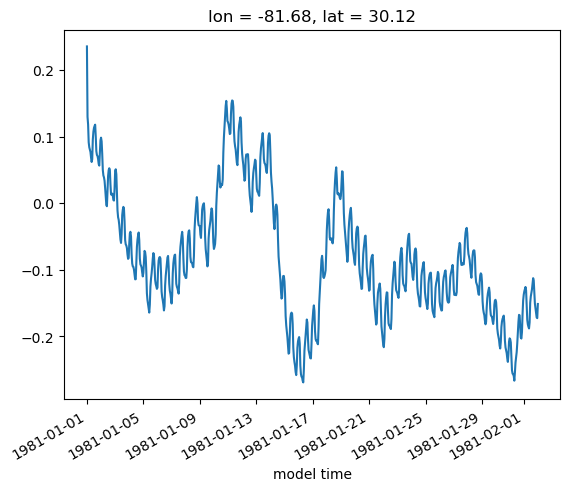

In [6]:

start_t = '1981-01-01'
end_t = '1981-02-01'


zeta_tslice = ds['zeta'].sel(time=slice(start_t,end_t),node=unique_nodes).compute()

num_ts =  len(zeta_tslice)
nodes = len(mapped_triangle)

t = np.zeros((num_ts,nodes,3),dtype=float)

for t_i in range(0,3):
    t[:,:,t_i] = zeta_tslice[:,mapped_triangle[:,t_i]] * weights[:,t_i] 

zeta_interp =  np.sum(t,axis=2)/ np.sum(weights,axis=1)

plot_arr = xarray.DataArray(data=zeta_interp,
         coords=dict(
        lon=(["node"], df.lon),
        lat=(["node"], df.lat),
        time=zeta_tslice.time),dims=["time","node"]
    )


plot_arr.plot()



del zeta_tslice



**Initializes the grid plotting function**

In [7]:
%run plot_grid.ipynb

/home/cheryl.morse/.conda/envs/DMAC_python/lib/python3.10/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.18, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


<br/> **Plot water level data from a specific date/time**

In [8]:

sel_time = "1985-01-01 01:00"

gridded_data = ds['zeta'].sel(time=sel_time).compute()

plot_gridded_output("Data at "+str(sel_time), gridded_data, "turbo", 500,350)

:DynamicMap   []
   :Overlay
      .WMTS.I                                                         :WMTS   [Longitude,Latitude]
      .Image.Data_at_1985_hyphen_minus_01_hyphen_minus_01_01_colon_00 :Image   [x,y]   (x_y vmax)

<br/>**Compute and plot the max water level over the selected timeframe**

In [9]:
%%time
zeta_sel =  ds['zeta'].sel(time=slice('1994-01-01','1994-01-01'))
grid_max = zeta_sel.max(dim='time').load()
plot_gridded_output("Maximum water level at each point", grid_max, "turbo", 500,350)


CPU times: user 5.91 s, sys: 2.07 s, total: 7.98 s
Wall time: 17.9 s


:DynamicMap   []
   :Overlay
      .WMTS.I                                  :WMTS   [Longitude,Latitude]
      .Image.Maximum_water_level_at_each_point :Image   [x,y]   (x_y vmax)

<br/>**Shutdown the cluster**

In [ ]:
%run shutdown_clusters.ipynb
shutdown_clusters()
